In [1]:
# Import libraries and dependencies
import ccxt
import os
import pandas as pd
from dotenv import load_dotenv

import numpy as np
import time
import datetime


In [2]:
#@title Cryptocurrency Selector
# user input for cyrpto coin
# user input for period

select_crypto = 'ETH' #@param ["BTC", "ETH", "XRP","ADA", "DOT", "CRO"]
select_period = '1d' #@param ["1m", "5m", "30m","1h", "1d", "1w"]

print(select_crypto)
print(select_period)


ETH
1d


In [3]:
# Load environment variables
load_dotenv()
curr = '/USD'
symbol = select_crypto  + curr
period = select_period
limit = 720

# Import environment variables
kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")
kraken = ccxt.kraken({"apiKey": kraken_public_key, "secret": kraken_secret_key})

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public_key)}")
print(f"Kraken secren data type: {type(kraken_secret_key)}")

Kraken key data type: <class 'str'>
Kraken secren data type: <class 'str'>


In [4]:
# function to pull crypto data
def fetch_crypto_data(crypto, interval, limit):
    interval_in_min = {'1m':1,'5m':5, '30m':30, '1h':60, '1d':1440, '1w':10080}
    no_of_data = limit * interval_in_min[interval]
    print(no_of_data)
    past_datetime = (datetime.datetime.now() + datetime.timedelta(minutes=240-no_of_data)).strftime('%Y-%m-%d %H:%M:%S')
    data = kraken.fetch_ohlcv(crypto, interval, kraken.parse8601(past_datetime))
    time.sleep(1)
    return data

In [5]:
data = fetch_crypto_data(symbol, period, limit)
df_kraken = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
#df_kraken['date'] = pd.to_datetime(df_kraken['date'],unit='ms')

# Set index as datetime object and drop extraneous columns
df_kraken.set_index(pd.to_datetime(df_kraken['Date'], unit='ms', infer_datetime_format=True), inplace=True)
df_kraken.drop(columns=['Date'], inplace=True)


1036800


In [6]:
df_kraken

,Open,High,Low,Close,Volume
Date,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089
2019-04-01,141.07,143.00,138.60,141.05,30807.373778
2019-04-02,141.01,167.76,140.77,164.62,121757.680737
2019-04-03,164.43,180.00,153.42,161.30,164618.080790
2019-04-04,161.05,165.20,153.53,157.51,70707.182046
...,...,...,...,...,...
2021-03-15,1847.80,1890.99,1735.72,1793.23,72686.990028
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516


In [7]:
df_kraken

,Open,High,Low,Close,Volume
Date,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089
2019-04-01,141.07,143.00,138.60,141.05,30807.373778
2019-04-02,141.01,167.76,140.77,164.62,121757.680737
2019-04-03,164.43,180.00,153.42,161.30,164618.080790
2019-04-04,161.05,165.20,153.53,157.51,70707.182046
...,...,...,...,...,...
2021-03-15,1847.80,1890.99,1735.72,1793.23,72686.990028
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516


In [8]:
# Drop NAs and calculate daily percent return
df_kraken['daily_return'] = df_kraken['Close'].dropna().pct_change()
df_kraken

,Open,High,Low,Close,Volume,daily_return
Date,,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,NaN
2019-04-01,141.07,143.00,138.60,141.05,30807.373778,-0.001699
2019-04-02,141.01,167.76,140.77,164.62,121757.680737,0.167104
2019-04-03,164.43,180.00,153.42,161.30,164618.080790,-0.020168
2019-04-04,161.05,165.20,153.53,157.51,70707.182046,-0.023497
...,...,...,...,...,...,...
2021-03-15,1847.80,1890.99,1735.72,1793.23,72686.990028,-0.029532
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910,0.006642
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516,0.010315


In [9]:
# Set short and long windows
short_window = 5
long_window = 20

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_close'] = df_kraken['Close'].ewm(halflife=short_window).mean()
df_kraken['slow_close'] = df_kraken['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df_kraken['crossover_long'] = np.where(df_kraken['fast_close'] > df_kraken['slow_close'], 1.0, 0.0)
df_kraken['crossover_short'] = np.where(df_kraken['fast_close'] < df_kraken['slow_close'], -1.0, 0.0)
df_kraken['crossover_signal'] = df_kraken['crossover_long'] + df_kraken['crossover_short']

df_kraken.head()

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,NaN,141.290000,141.290000,0.0,0.0,0.0
2019-04-01,141.07,143.00,138.60,141.05,30807.373778,-0.001699,141.161696,141.167921,0.0,-1.0,-1.0
2019-04-02,141.01,167.76,140.77,164.62,121757.680737,0.167104,150.086603,149.257720,1.0,0.0,1.0
2019-04-03,164.43,180.00,153.42,161.30,164618.080790,-0.020168,153.496834,152.426558,1.0,0.0,1.0
2019-04-04,161.05,165.20,153.53,157.51,70707.182046,-0.023497,154.535838,153.514910,1.0,0.0,1.0


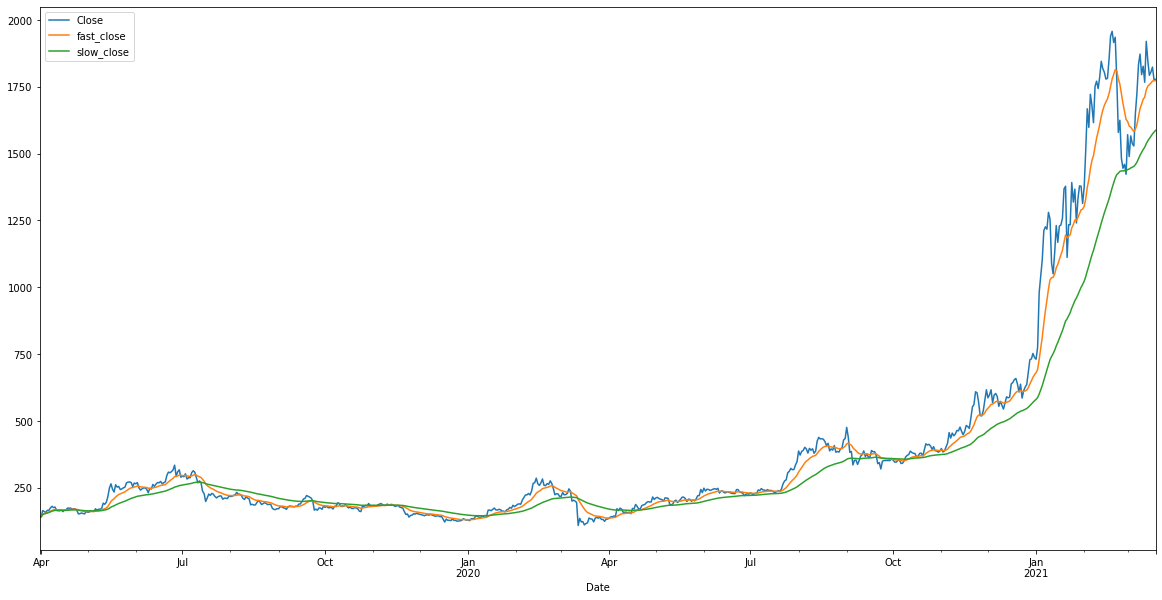

In [10]:
# Plot the EMA of ETH/USD closing prices
df_kraken[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [11]:
# Set short and long volatility windows
short_vol_window = 5
long_vol_window = 25

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df_kraken['fast_vol'] = df_kraken['daily_return'].ewm(halflife=short_vol_window).std()
df_kraken['slow_vol'] = df_kraken['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
df_kraken['vol_trend_long'] = np.where(df_kraken['fast_vol'] < df_kraken['slow_vol'], 1.0, 0.0)
df_kraken['vol_trend_short'] = np.where(df_kraken['fast_vol'] > df_kraken['slow_vol'], -1.0, 0.0) 
df_kraken['vol_trend_signal'] = df_kraken['vol_trend_long'] + df_kraken['vol_trend_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,NaN,141.290000,141.290000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2019-04-01,141.07,143.00,138.60,141.05,30807.373778,-0.001699,141.161696,141.167921,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2019-04-02,141.01,167.76,140.77,164.62,121757.680737,0.167104,150.086603,149.257720,1.0,0.0,1.0,0.119361,0.119361,1.0,0.0,1.0
2019-04-03,164.43,180.00,153.42,161.30,164618.080790,-0.020168,153.496834,152.426558,1.0,0.0,1.0,0.104095,0.103357,0.0,-1.0,-1.0
2019-04-04,161.05,165.20,153.53,157.51,70707.182046,-0.023497,154.535838,153.514910,1.0,0.0,1.0,0.090190,0.091347,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,1847.80,1890.99,1735.72,1793.23,72686.990028,-0.029532,1757.965122,1556.221979,1.0,0.0,1.0,0.050822,0.056971,1.0,0.0,1.0
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910,0.006642,1764.071884,1564.701040,1.0,0.0,1.0,0.047424,0.056188,1.0,0.0,1.0
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516,0.010315,1771.798477,1573.525540,1.0,0.0,1.0,0.044289,0.055415,1.0,0.0,1.0


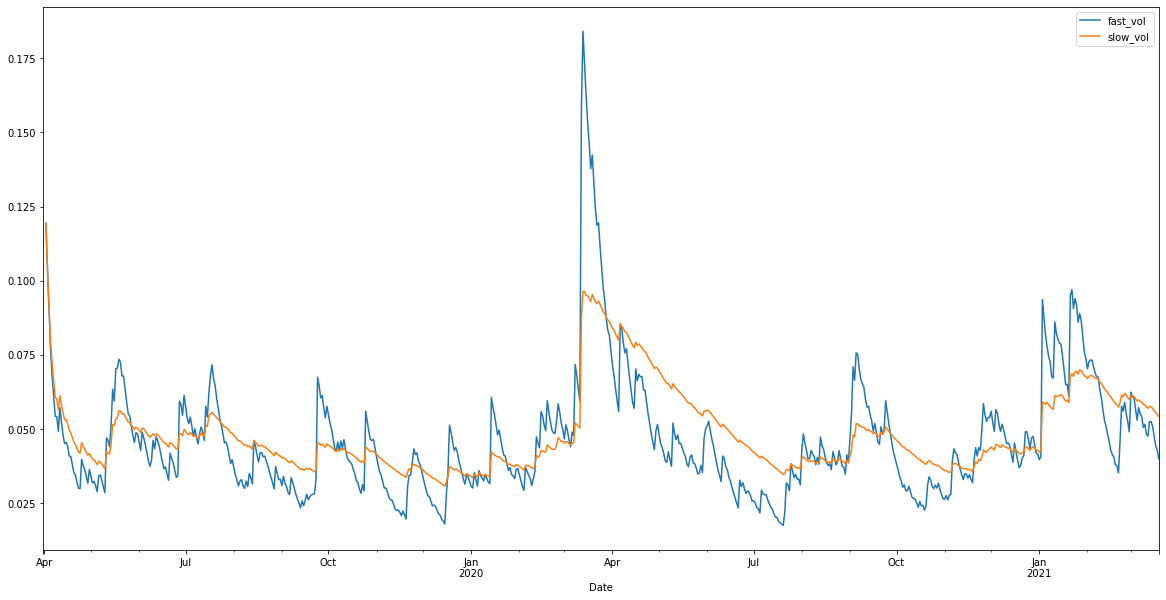

In [12]:
# Plot the EMA of BTC/USD daily return volatility
df_kraken[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [13]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df_kraken['bollinger_mid_band'] = df_kraken['Close'].rolling(window=bollinger_window).mean()
df_kraken['bollinger_std'] = df_kraken['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df_kraken['bollinger_upper_band']  = df_kraken['bollinger_mid_band'] + (df_kraken['bollinger_std'] * 1)
df_kraken['bollinger_lower_band']  = df_kraken['bollinger_mid_band'] - (df_kraken['bollinger_std'] * 1)

# Calculate bollinger band trading signal
df_kraken['bollinger_long'] = np.where(df_kraken['Close'] < df_kraken['bollinger_lower_band'], 1.0, 0.0)
df_kraken['bollinger_short'] = np.where(df_kraken['Close'] > df_kraken['bollinger_upper_band'], -1.0, 0.0)
df_kraken['bollinger_signal'] = df_kraken['bollinger_long'] + df_kraken['bollinger_short']

df_kraken

,Open,High,Low,Close,Volume,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-31,142.11,142.14,140.13,141.29,7464.446089,NaN,141.290000,141.290000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-04-01,141.07,143.00,138.60,141.05,30807.373778,-0.001699,141.161696,141.167921,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-04-02,141.01,167.76,140.77,164.62,121757.680737,0.167104,150.086603,149.257720,1.0,0.0,1.0,0.119361,0.119361,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-04-03,164.43,180.00,153.42,161.30,164618.080790,-0.020168,153.496834,152.426558,1.0,0.0,1.0,0.104095,0.103357,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-04-04,161.05,165.20,153.53,157.51,70707.182046,-0.023497,154.535838,153.514910,1.0,0.0,1.0,0.090190,0.091347,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,1847.80,1890.99,1735.72,1793.23,72686.990028,-0.029532,1757.965122,1556.221979,1.0,0.0,1.0,0.050822,0.056971,1.0,0.0,1.0,1658.1370,164.111529,1822.248529,1494.025471,0.0,0.0,0.0
2021-03-16,1794.11,1818.00,1712.03,1805.14,49192.414910,0.006642,1764.071884,1564.701040,1.0,0.0,1.0,0.047424,0.056188,1.0,0.0,1.0,1667.1435,167.113171,1834.256671,1500.030329,0.0,0.0,0.0
2021-03-17,1805.69,1839.54,1743.01,1823.76,47484.969516,0.010315,1771.798477,1573.525540,1.0,0.0,1.0,0.044289,0.055415,1.0,0.0,1.0,1684.2475,164.619259,1848.866759,1519.628241,0.0,0.0,0.0


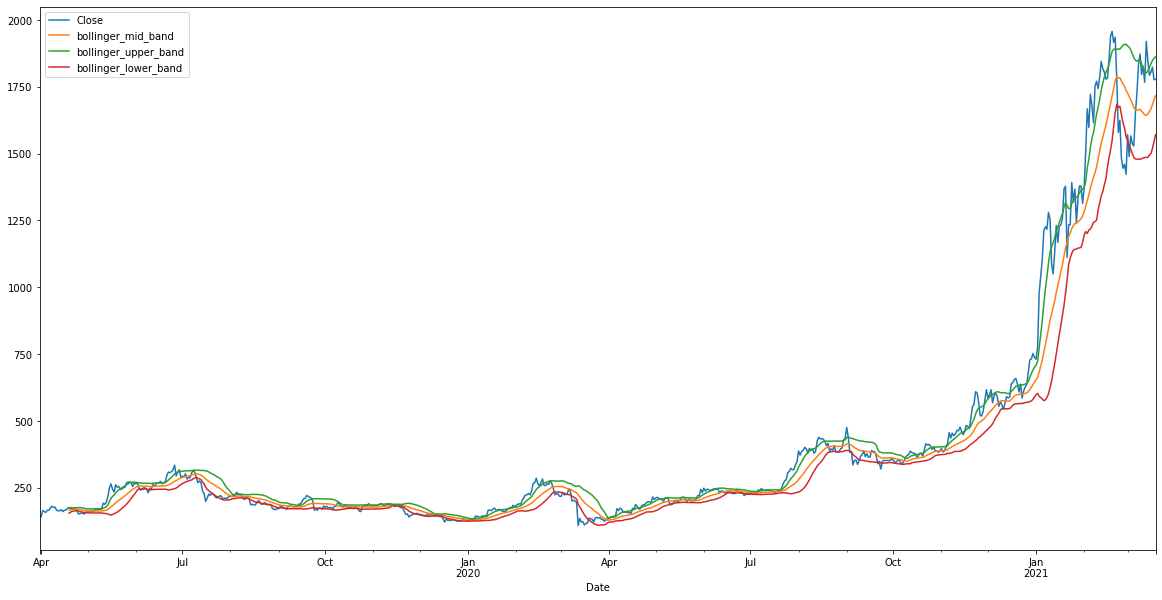

In [14]:
# Plot the Bollinger Bands for BTC/USD closing prices
df_kraken[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [15]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']
df_kraken[x_var_list] = df_kraken[x_var_list].shift(1)
df_kraken[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-03-15,1.0,1.0,-1.0
2021-03-16,1.0,1.0,0.0
2021-03-17,1.0,1.0,0.0
2021-03-18,1.0,1.0,0.0
2021-03-19,1.0,1.0,0.0


In [16]:
# Drop NAs and replace positive/negative infinity values
df_kraken.dropna(inplace=True)
df_kraken.dropna(subset=['daily_return'], inplace=True)
df_kraken = df_kraken.replace([np.inf, -np.inf], np.nan)

#populate Positive Return based on Daily Return
df_kraken['Positive Return'] = np.where(df_kraken['daily_return'] > 0, 1.0, 0.0)

In [17]:
# Construct training start and end dates
training_start = df_kraken.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-08-20'

# Construct testing start and end dates
testing_start =  '2020-08-21'
testing_end = df_kraken.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_kraken[x_var_list][training_start:training_end]
y_train = df_kraken['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_kraken[x_var_list][testing_start:testing_end]
y_test = df_kraken['Positive Return'][testing_start:testing_end]

In [18]:
df_kraken.to_csv('kraken_pull_EthExample.csv')